In [1]:
import momepy
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, box, MultiLineString
from shapely.ops import unary_union
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas as dgd
import dask.distributed
import deltalake
import shapely.geometry
import mercantile
import rasterio
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import shape, Polygon, mapping, box, LineString
from rasterio.features import shapes
import osmnx as ox
import os
from tqdm import tqdm

c:\ProgramData\anaconda3\envs\downloader\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
latlng = (lat, lng)

In [4]:
if not os.path.exists(f'./output/{place}'):
    os.makedirs(f'./output/{place}')

## part 1: Find limits of cells to download

In [5]:
def create_square(center_point, distance):
    """
    Create a square polygon centered on the given point.
    The 'distance' parameter is half the side length of the square.
    """
    x, y = center_point.x, center_point.y
    return Polygon([(x - distance, y - distance),
                    (x - distance, y + distance),
                    (x + distance, y + distance),
                    (x + distance, y - distance)])

# Create a GeoSeries with the specified point
gdf = gpd.GeoSeries([Point(latlng[1], latlng[0])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((latlng[1] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if latlng[0] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'
    
# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Get the center point in UTM coordinates
center_point = gdf_utm[0]

# Create a square polygon centered on the point
square = create_square(center_point, radius * 1000)  # Convert km to meters

# Create a GeoSeries for the square in UTM coordinates
square_gs_utm = gpd.GeoSeries([square], crs=gdf_utm.crs)

# Reproject the square back to the original CRS
area_of_interest = square_gs_utm.to_crs(crs)

# Plotting
area_of_interest.explore()

In [6]:
# # Create a GeoDataFrame with the specified point
# gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# # Reproject to a coordinate system that uses meters (UTM)
# gdf_utm = gdf.to_crs(epsg=local_crs)

# # Create a 50 km buffer around the point
# buffer = gdf_utm.buffer(10000)  # 50 km buffer

# # Reproject buffer back to original CRS
# area_of_interest = buffer.to_crs(epsg=crs)

# # Plottin
# area_of_interest.explore()



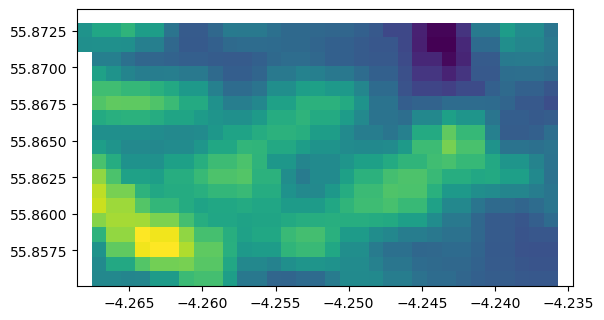

In [7]:
# Read only the portion of the GeoTIFF that intersects with the AOI

cell_polygons = []
with rasterio.open("output/built_height.tif") as src:
    # Calculate the window to read based on AOI bounds
    out_image, transformed = rasterio.mask.mask(src, area_of_interest, crop=True, filled=True)
    out_profile = src.profile.copy()
    
out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed})
with rasterio.open(f"output/{place}.tif", 'w', **out_profile) as dst:
    dst.write(out_image)
    
with rasterio.open(f"output/{place}.tif") as src:
    show(src)

In [8]:
def get_cell_polygon(x, y, transform):
    """
    Create a polygon for the given cell coordinates (x, y) using the affine transform.
    """
    tl = transform * (x, y)
    tr = transform * (x + 1, y)
    br = transform * (x + 1, y + 1)
    bl = transform * (x, y + 1)
    return Polygon([tl, tr, br, bl, tl])

In [9]:
mask = None
with rasterio.Env():
    with rasterio.open(f"output/{place}.tif") as src:
        image = src.read(1) # first band
        transform = src.transform

        # Prepare schema for shapefile
        schema = {
            'properties': [('raster_val', 'int')],
            'geometry': 'Polygon'
        }

        # with fiona.open(f"output/{place}/height_cells.shp", 'w', 
        #                 driver='ESRI Shapefile',
        #                 crs=src.crs,
        #                 schema=schema) as dst:
            
        #     # Iterate over each pixel in the raster
        #     for row in tqdm(range(image.shape[0])):
        #         for col in range(image.shape[1]):
        #             value = image[row, col]
        #             polygon = get_cell_polygon(col, row, transform)
        #             dst.write({
        #                 'properties': {'raster_val': int(value)},
        #                 'geometry': mapping(polygon)
        #             })
        
        # List to hold each feature
        features = []

        # Iterate over each pixel in the raster
        for row in tqdm(range(image.shape[0])):
            for col in range(image.shape[1]):
                value = image[row, col]
                polygon = get_cell_polygon(col, row, transform)
                features.append({
                    'properties': {'raster_val': int(value)},
                    'geometry': polygon
                })

        # Create a GeoDataFrame
        area_of_interest = gpd.GeoDataFrame([f['properties'] for f in features],
                            geometry=[f['geometry'] for f in features],
                            crs=src.crs)
        
        area_of_interest.to_parquet(f"output/{place}/height_cells.shp")


100%|██████████| 19/19 [00:00<00:00, 724.89it/s]


# part 2: create a buffer that is slightly larger to account for edge effects and download all building footprints + street data

In [10]:
# Get bounds
minx, miny, maxx, maxy = area_of_interest.total_bounds
min_dist = min([abs(minx-latlng[0]), abs(miny-latlng[1]), abs(maxx-latlng[0]), abs(maxy-latlng[1])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(latlng[1], latlng[0])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((latlng[1] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if latlng[0] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'

# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Create a 50 km buffer around the point
buffer_circle = gdf_utm.buffer((radius+5) * 1000)  # Convert km to meters

buffer = buffer_circle

# Reproject buffer back to original CRS
buffer = buffer.to_crs(crs)

# Plotting
buffer.explore()


In [11]:
# # This creates a boolean mask where each element is True if the geometry in `gdf` is within any geometry in `area_of_interest`
# mask = area_of_interest.geometry.apply(lambda geom: any(geom.within(aoi_geom) for aoi_geom in buffer.geometry))

# # Apply the mask to select only the relevant features
# selected_features = area_of_interest[mask]

In [12]:
# selected_features_union = selected_features.unary_union

# selected_features_union = gpd.GeoSeries([selected_features_union]).set_crs(epsg=4326)

In [13]:
# selected_features_union.plot()

In [14]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")

asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}
table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*buffer[0].bounds, zooms=9)
]
quadkeys

uris = table.file_uris([("quadkey", "in", quadkeys)])
uris

df = dgd.read_parquet(uris, storage_options=storage_options)


In [15]:
buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()

C:\Users\reube\AppData\Local\Temp\ipykernel_5084\1505170059.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()


In [16]:
if country == None:
    world_poly = gpd.read_file(f"input/{place}_study_area.shp")
else:
    world_poly = gpd.read_file(f"input/{country}_study_area.shp")

In [17]:
water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})
water_gdf = water_gdf[water_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

C:\Users\reube\AppData\Local\Temp\ipykernel_5084\2221155826.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})


In [18]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in water_gdf.columns if col != 'geometry']

# Drop these columns
water_gdf = water_gdf.drop(columns=columns_to_drop)

In [19]:
buffer = gpd.GeoDataFrame(geometry=buffer)

In [20]:
water_gdf = water_gdf.reset_index(drop=True)

In [21]:
world_poly

,FID,geometry
0,0,"POLYGON ((-4.94237 55.72545, -4.94192 55.72559..."
1,1,"POLYGON ((-4.94051 55.72458, -4.94049 55.72407..."
2,2,"POLYGON ((-4.73290 55.52496, -4.73380 55.52495..."
3,3,"POLYGON ((-4.95385 55.16290, -4.95388 55.16341..."
4,4,"POLYGON ((-1.75372 50.72274, -1.75350 50.72284..."
...,...,...
15455,747321,"POLYGON ((-6.30055 56.49181, -6.30046 56.49177..."
15456,747322,"POLYGON ((-6.30165 56.49486, -6.30157 56.49487..."
15457,747323,"POLYGON ((-6.30188 56.49527, -6.30185 56.49515..."
15458,747324,"POLYGON ((-6.30315 56.49444, -6.30308 56.49451..."


In [22]:
buffer = world_poly.overlay(buffer, how='intersection').overlay(water_gdf, how='difference')

In [23]:
buffer

,FID,geometry
0,371628,"MULTIPOLYGON (((-4.23675 55.91668, -4.23476 55..."


In [24]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in buffer.columns if col != 'geometry']

# Drop these columns
buffer = buffer.drop(columns=columns_to_drop)

In [25]:
buffer_new = buffer.dissolve()

In [26]:
buffer_new.to_parquet(f"./output/{place}/study_area.pq")

<Axes: >

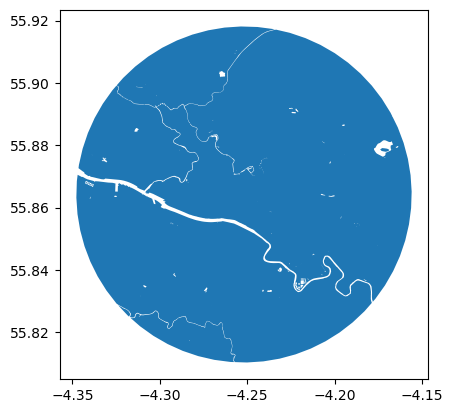

In [27]:
buffer_new.plot()

In [28]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='drive', truncate_by_edge=True, retain_all=True)
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
streets = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

streets.head()

osmid  oneway        highway  \
u          v          key                                                 
194811     4142791667 0    [33912746, 521587562]    True  motorway_link   
           839236899  0    [200051860, 45773620]    True       motorway   
           190451507  0                 45773620    True       motorway   
4142791667 30037545   0                412958509    True  motorway_link   
           388566046  0                521587562    True  motorway_link   

                                   maxspeed reversed   length  \
u          v          key                                       
194811     4142791667 0    [70 mph, 30 mph]    False  260.270   
           839236899  0    [50 mph, 70 mph]    False  765.733   
           190451507  0              70 mph    False  967.817   
4142791667 30037545   0              30 mph    False   45.766   
           388566046  0              30 mph    False   41.206   

                                                                    geometry  \
u          v          key                                                      
194811     4142791667 0    LINESTRING (254595.109 664390.697, 254660.836 ...   
           839236899  0    LINESTRING (254595.109 664390.697, 254660.232 ...   
           190451507  0    LINESTRING (253684.000 664697.747, 253722.925 ...   
4142791667 30037545   0    LINESTRING (254849.562 664336.774, 254873.037 ...   
           388566046  0    LINESTRING (254849.562 664336.774, 254876.557 ...   

                                 from          to lanes  ref bridge name  \
u          v          key                                                  
194811     4142791667 0        194811  4142791667   NaN  NaN    NaN  NaN   
           839236899  0        194811   839236899     3   M8    NaN  NaN   
           190451507  0     190451507      194811     3   M8    NaN  NaN   
4142791667 30037545   0    4142791667    30037545   NaN  NaN    NaN  NaN   
           388566046  0    4142791667   388566046   NaN  NaN    NaN  NaN   

                          tunnel access junction width  
u          v          key                               
194811     4142791667 0      NaN    NaN      NaN   NaN  
           839236899  0      NaN    NaN      NaN   NaN  
           190451507  0      NaN    NaN      NaN   NaN  
4142791667 30037545   0      NaN    NaN      NaN   NaN  
           388566046  0      NaN    NaN      NaN   NaN

<Axes: >

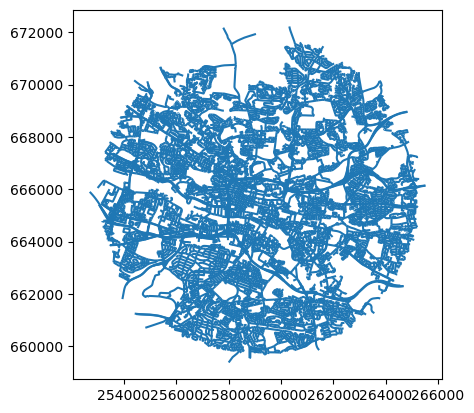

In [29]:
streets.plot()

In [30]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in streets.columns if col != 'geometry']

# Drop these columns
streets = streets.drop(columns=columns_to_drop)

In [31]:
# Assuming your GeoDataFrame is named 'gdf'
line_strings = []
for geometry in streets.geometry:
    if geometry.geom_type == 'LineString':
        line_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        line_strings.extend(list(geometry))

In [32]:
collection = shapely.GeometryCollection(line_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
streets_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

In [33]:
# Assuming streets is your existing GeoDataFrame

# Function to break apart MultiLineStrings
def explode_multilinestring(multilinestring):
    if isinstance(multilinestring, MultiLineString):
        return list(multilinestring)
    else:
        return [multilinestring]

# Explode all MultiLineStrings into individual LineStrings
exploded_lines = [explode_multilinestring(geom) for geom in streets.geometry]

# Flatten the list of lists into a single list of geometries
flat_list = [item for sublist in exploded_lines for item in sublist]

# Create a new GeoDataFrame
streets_noded_gdf = gpd.GeoDataFrame(geometry=flat_list)

<Axes: >

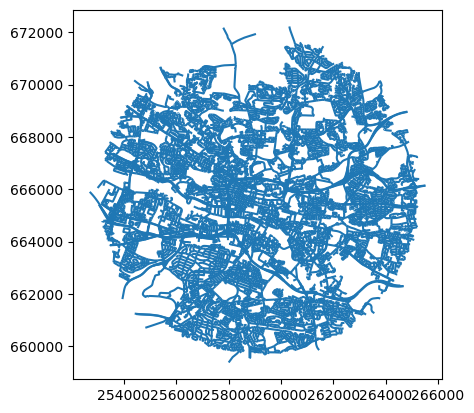

In [34]:
streets_noded_gdf.plot()

In [35]:
streets_noded_gdf = streets_noded_gdf.set_crs(local_crs)

In [36]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='all', custom_filter='["railway"~"rail"]["tunnel"!="yes"]')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
rail = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

rail.head()



osmid                  name  \
u           v           key                                                 
1646877700  10067781843 0                 151849651         Shields Depot   
10067781843 1646877605  0                 151849651         Shields Depot   
            10067781841 0                1099754270         Shields Depot   
1646867460  3719807241  0                 778011377                   NaN   
            1646867377  0    [778011377, 368122724]  West Coast Main Line   

                            service  oneway reversed   length         from  \
u           v           key                                                  
1646877700  10067781843 0    siding   False     True  321.227  10067781843   
10067781843 1646877605  0    siding   False     True   42.283   1646877605   
            10067781841 0    siding   False     True  466.896  10067781841   
1646867460  3719807241  0       NaN   False     True   46.429   3719807241   
            1646867377  0       NaN   False    False  279.080   1646867377   

                                      to  \
u           v           key                
1646877700  10067781843 0     1646877700   
10067781843 1646877605  0    10067781843   
            10067781841 0    10067781843   
1646867460  3719807241  0     1646867460   
            1646867377  0     1646867460   

                                                                      geometry  \
u           v           key                                                      
1646877700  10067781843 0    LINESTRING (256700.714 663944.413, 257020.935 ...   
10067781843 1646877605  0    LINESTRING (256658.568 663949.251, 256700.714 ...   
            10067781841 0    LINESTRING (257165.507 663887.534, 256728.481 ...   
1646867460  3719807241  0    LINESTRING (258551.670 663979.672, 258540.651 ...   
            1646867377  0    LINESTRING (258480.685 663663.950, 258479.707 ...   

                              ref          maxspeed bridge  
u           v           key                                 
1646877700  10067781843 0     NaN               NaN    NaN  
10067781843 1646877605  0     NaN               NaN    NaN  
            10067781841 0     NaN               NaN    NaN  
1646867460  3719807241  0    WCM2            25 mph    NaN  
            1646867377  0    WCM2  [25 mph, 30 mph]    NaN

In [37]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in rail.columns if col != 'geometry']

# Drop these columns
rail = rail.drop(columns=columns_to_drop).reset_index(drop=True)

In [38]:
# Assuming your GeoDataFrame is named 'gdf'
rail_strings = []
for geometry in rail.geometry:
    if geometry.geom_type == 'LineString':
        rail_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        rail_strings.extend(list(geometry))

In [39]:
collection = shapely.GeometryCollection(rail_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
rail_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

<Axes: >

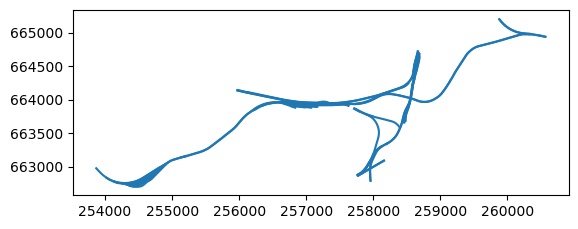

In [40]:
rail_noded_gdf.plot()

In [41]:
buildings

,geometry,meanHeight,RegionName,quadkey,index_right
0,"POLYGON ((-4.33730 55.88284, -4.33731 55.88290...",-1.0,UnitedKingdom,31133223,0
3,"POLYGON ((-4.26986 55.81709, -4.26984 55.81717...",-1.0,UnitedKingdom,31133223,0
5,"POLYGON ((-4.22700 55.87941, -4.22706 55.87942...",-1.0,UnitedKingdom,31133223,0
10,"POLYGON ((-4.25613 55.81663, -4.25609 55.81661...",-1.0,UnitedKingdom,31133223,0
30,"POLYGON ((-4.33047 55.86413, -4.33089 55.86414...",-1.0,UnitedKingdom,31133223,0
...,...,...,...,...,...
286472,"POLYGON ((-4.21238 55.85196, -4.21233 55.85202...",-1.0,UnitedKingdom,31133232,0
286507,"POLYGON ((-4.18743 55.85592, -4.18742 55.85583...",-1.0,UnitedKingdom,31133232,0
286512,"POLYGON ((-4.20559 55.91044, -4.20553 55.91036...",-1.0,UnitedKingdom,31133232,0
286519,"POLYGON ((-4.19332 55.86785, -4.19329 55.86795...",-1.0,UnitedKingdom,31133232,0


In [42]:
buildings = buildings[["geometry"]]

In [43]:
buildings = gpd.sjoin(buildings, buffer_new, how="left", op="within")

c:\ProgramData\anaconda3\envs\downloader\Lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [44]:
buildings = buildings[buildings["index_right"] == 0][["geometry"]]

In [45]:
buildings.to_parquet(f"./output/{place}/buildings_raw.pq")

streets_noded_gdf.to_parquet(f"./output/{place}/streets_raw.pq")

rail_noded_gdf.to_parquet(f"./output/{place}/rail_raw.pq")

<Axes: >

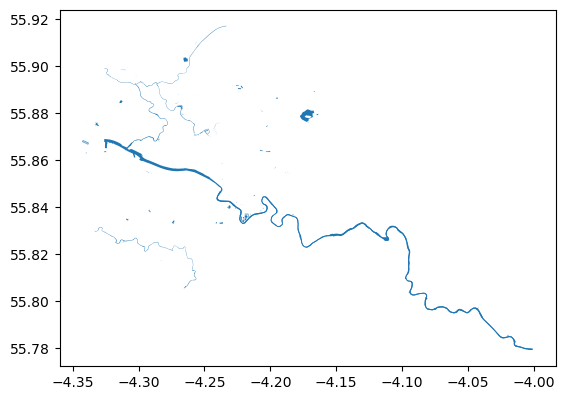

In [46]:
water_gdf.plot()

In [47]:
water_gdf.to_parquet(f"./output/{place}/water.pq")